In [33]:
from typing import List, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GroupKFold, TimeSeriesSplit
import xgboost as xgb
import catboost as catb
from typing import List, Tuple
import scipy.stats as st
%matplotlib inline


In [34]:
TRAIN_DATA_PATH = 'data/assignment_2_train.csv'
TEST_DATA_PATH = 'data/assignment_2_test.csv'


train = pd.read_csv(TRAIN_DATA_PATH)
test = pd.read_csv(TEST_DATA_PATH)

print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 180000 rows, 394 cols
test.shape = 100001 rows, 394 cols


In [35]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,1.800000e+05,180000.000000,1.800000e+05,180000.000000,180000.000000,177389.000000,179997.000000,179047.000000,160567.000000,160567.000000,...,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000
mean,3.077000e+06,0.028561,1.909818e+06,129.514237,9860.225806,368.326897,153.410374,200.363089,291.160444,86.559903,...,0.137074,74.962242,99.220468,85.778161,8.326725,18.404676,12.437524,26.798593,32.005349,28.492421
std,5.196167e+04,0.166570,1.039029e+06,206.515032,4910.778205,158.952840,11.529483,40.585532,102.250385,3.958070,...,0.642444,545.161980,668.223140,577.072150,84.616132,120.896921,99.305885,252.695682,284.870583,258.372941
min,2.987000e+06,0.000000,8.640000e+04,0.292000,1001.000000,100.000000,100.000000,100.000000,100.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.032000e+06,0.000000,1.091681e+06,44.000000,6019.000000,215.000000,150.000000,166.000000,204.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.077000e+06,0.000000,1.884075e+06,75.000000,9633.000000,375.000000,150.000000,226.000000,299.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.121999e+06,0.000000,2.693196e+06,125.000000,14182.000000,514.000000,150.000000,226.000000,330.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.166999e+06,1.000000,3.958317e+06,5278.950000,18396.000000,600.000000,231.000000,237.000000,540.000000,102.000000,...,15.000000,20750.000000,32250.000000,21250.000000,3100.000000,3350.000000,3250.000000,8250.000000,8250.000000,8250.000000


In [37]:
# test.head()

### Даны выборки для обучения и для тестирования. Задание заключается в том, чтобы попробовать разные способы валидации, проанализировать плюсы / минусы каждой и сделать выводы о том, какой способ валидации наиболее устойчивый в данной задаче. Метрика качества для оценки прогнозов - ROC-AUC, название целевой переменной - IsFraud. Рекомендуется использовать модели градиетного бустинга, реализация любая, гипепараметры любые. Внимание! выборка    _assignment_2_test.csv_ - наш аналог лидерборда. Будем моделировать ситуацию отправки решения на лидерборд и сравнить значение метрики на лидерборде и на локальной валидации. Для других целей использовать выборку запрещено!.

Терминалогия, используемая в задании:
* обучающая выборка - выборка, которая передается в метод
fit / train ;
* валидационная выборка - выборка, которая получается при Hold-Out на 2 выборки (
train , valid );
* тестовая выборка - выборка, которая получается при Hold-Out на 3 выборки (
train , valid , test );
* ЛБ - лидерборд, выборка
assignment_2_test.csv .

### Задание 1: сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (TransactionID), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на валидационной выборке, оценить расхождение по сравнению с качеством на обучающей выборке и валидационной выборке. Оценить качество на ЛБ, сравнить с качеством на обучении и валидации. Сделать выводы.

### Задание 2: сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1. для каждой выборки

### Задание 3: построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на ЛБ относительно полученного доверительного интервала. Сделать выводы.

### Задание 4: выполнить Adversarial Validation, подобрать объекты из обучающей выборки, которые сильно похожи на объекты из assignment_2_test.csv , и использовать их в качестве валидационного набора. Оценить качество модели на ЛБ, сделать выводы о полученных результатах.

### Задание 5: сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных; Оценить качество на ЛБ, сделать выводы.

### Задание 6 (опциональное): сделать Hold-Out валидацию по времени (TransactionDT), повторить процедуры из п.1 / п.2 (на ваш выбор). Построить доверительный интервал, сравнить качество на ЛБ выборке с полученным доверительным интервалом. Сделать выводы.

### Задание 7 (совсем опциональное): в данном наборе данных у нас есть ID-транзакции (TransactionID) и время транзакции (TransactionDT), но отсутствует ID-клиента, который совершал транзакции. Кажется, что в этой задаче валидация по клиенту работала бы хорошо. Предложить критерий, по которому можно выделить клиентов и сделать п.5, используя созданное определение клиента, используя валидацию по клиенту (GroupKFold).

## Hold-Out Validation (с разбиением на 2 выборки)

In [38]:
### Settings

seed = 42
np.random.seed(seed)
discret_limit = 25

ID = 'TransactionID'
DATE = 'TransactionDT'
TARGET = 'isFraud' # Target

CAT_FEATS = train.select_dtypes(include='object').columns  # Categorical
ALL_NUMERICAL_FEATS = train.select_dtypes(include=[np.number]).columns # Numerical + Target
NUMERICAL_FEATS = ALL_NUMERICAL_FEATS.drop([TARGET, ID, DATE]) # Numerical only

# Discrete feature among numerical
DISCRETE_FEATS = [feature for feature in NUMERICAL_FEATS if len(train[feature].unique()) < discret_limit]

print(f"Categorical Features Count: {len(CAT_FEATS)}")
print(f"Numerical Features Count: {len(NUMERICAL_FEATS)}")
print(f"Discrete Features of Numerical Count: {len(DISCRETE_FEATS)}")
print(f"\nTotal Features: {len(train.columns)-1}")

Categorical Features Count: 14
Numerical Features Count: 377
Discrete Features of Numerical Count: 180

Total Features: 393


In [39]:
# Hold-out Validation
X = train[NUMERICAL_FEATS]
y = train[TARGET]

# LB Validation
X_val = test[NUMERICAL_FEATS]
y_val = test[TARGET]


# Split train dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

print("x_train.shape = {} rows, {} cols".format(*X_train.shape))
print("x_test.shape = {} rows, {} cols".format(*X_test.shape))
print("x_LB.shape = {} rows, {} cols".format(*X_val.shape))

x_train.shape = 126000 rows, 377 cols
x_test.shape = 54000 rows, 377 cols
x_LB.shape = 100001 rows, 377 cols


In [40]:
model = xgb.XGBClassifier(random_state=seed, n_jobs=4)

model.fit(X_train,
          y_train,
          eval_set=[(X_test, y_test)],
          early_stopping_rounds=5,
          eval_metric="auc"
         )

[0]	validation_0-auc:0.75457
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.81467
[2]	validation_0-auc:0.82195
[3]	validation_0-auc:0.82434
[4]	validation_0-auc:0.83614
[5]	validation_0-auc:0.83855
[6]	validation_0-auc:0.86326
[7]	validation_0-auc:0.86600
[8]	validation_0-auc:0.86801
[9]	validation_0-auc:0.87629
[10]	validation_0-auc:0.88284
[11]	validation_0-auc:0.88596
[12]	validation_0-auc:0.88821
[13]	validation_0-auc:0.88963
[14]	validation_0-auc:0.89382
[15]	validation_0-auc:0.89612
[16]	validation_0-auc:0.89782
[17]	validation_0-auc:0.90042
[18]	validation_0-auc:0.90158
[19]	validation_0-auc:0.90398
[20]	validation_0-auc:0.90450
[21]	validation_0-auc:0.90513
[22]	validation_0-auc:0.90565
[23]	validation_0-auc:0.90645
[24]	validation_0-auc:0.90745
[25]	validation_0-auc:0.90803
[26]	validation_0-auc:0.90853
[27]	validation_0-auc:0.90843
[28]	validation_0-auc:0.91032
[29]	validation_0-auc:0.91091
[30]	validation_0-auc:0.91209
[31]	validation_0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [41]:
train_score = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
test_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
val_score = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])

print(f"Hold-Out Train splitted validation")
print(f"Train-score: {round(train_score, 3)}, Test-score: {round(test_score, 3)}, ** LB-score: {round(val_score, 3)}")

Hold-Out Train splitted validation
Train-score: 0.975, Test-score: 0.927, ** LB-score: 0.842


Train-score: 0.975, Test-score: 0.927 - В данном случае классификатор значительно переобучился. Переподгонка ещё сильнее проявляется на новых данных (test датасете)

### Задание 2: сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1. для каждой выборки

## Hold-Out Validation (с разбиением на 3 выборки)

In [42]:
X = train[NUMERICAL_FEATS]
y = train[TARGET]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=seed)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.3, random_state=seed)


print("x_train.shape = {} rows, {} cols".format(*X_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*X_val.shape))
print("x_test.shape = {} rows, {} cols".format(*X_test.shape))

x_train.shape = 126000 rows, 377 cols
x_valid.shape = 37800 rows, 377 cols
x_test.shape = 16200 rows, 377 cols


In [43]:
model = xgb.XGBClassifier(random_state=seed, n_jobs=4)
model.fit(X_train,
          y_train,
          eval_set=[(X_val, y_val)],
          early_stopping_rounds=5,
          eval_metric="auc"
         )

[0]	validation_0-auc:0.75111
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.81004
[2]	validation_0-auc:0.81907
[3]	validation_0-auc:0.82114
[4]	validation_0-auc:0.83290
[5]	validation_0-auc:0.83612
[6]	validation_0-auc:0.86155
[7]	validation_0-auc:0.86426
[8]	validation_0-auc:0.86603
[9]	validation_0-auc:0.87313
[10]	validation_0-auc:0.88109
[11]	validation_0-auc:0.88513
[12]	validation_0-auc:0.88749
[13]	validation_0-auc:0.88818
[14]	validation_0-auc:0.89178
[15]	validation_0-auc:0.89354
[16]	validation_0-auc:0.89502
[17]	validation_0-auc:0.89801
[18]	validation_0-auc:0.89827
[19]	validation_0-auc:0.90149
[20]	validation_0-auc:0.90229
[21]	validation_0-auc:0.90264
[22]	validation_0-auc:0.90307
[23]	validation_0-auc:0.90365
[24]	validation_0-auc:0.90510
[25]	validation_0-auc:0.90567
[26]	validation_0-auc:0.90579
[27]	validation_0-auc:0.90576
[28]	validation_0-auc:0.90850
[29]	validation_0-auc:0.90919
[30]	validation_0-auc:0.91037
[31]	validation_0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [44]:
train_score = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
valid_score = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
test_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print(f"Train-score: {round(train_score, 3)}, Valid-score: {round(valid_score, 3)}, Test-score: {round(test_score, 3)}")

Train-score: 0.975, Valid-score: 0.925, Test-score: 0.932


Hold-Out с 3 разбиениями показал себя также, плюс к этому Test-score поднялся на ненамного.

### Задание 3: построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на ЛБ относительно полученного доверительного интервала. Сделать выводы.

## Доверительный интервал на основе BootStrap выборок

In [45]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [46]:
scores = create_bootstrap_metrics(y_test, model.predict(X_test), roc_auc_score)

calculate_confidence_interval(scores)

(0.7093603112524034, 0.754145644140848)

C:\Users\User\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


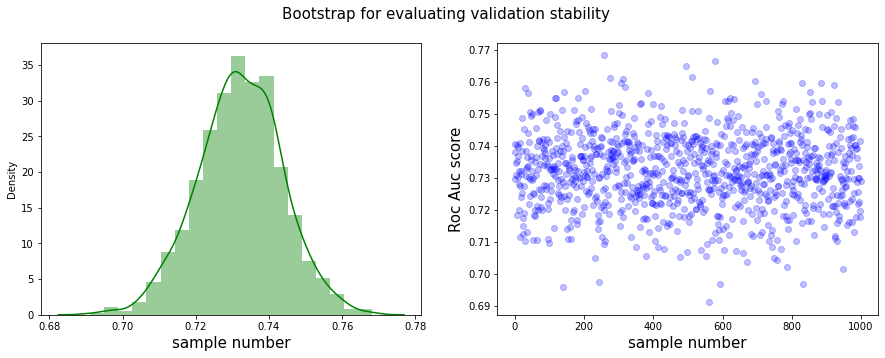

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(scores)), scores, alpha=0.25, color="blue")
axes[1].set_xlabel("sample number", size=15)
axes[1].set_ylabel("Roc Auc score", size=15)

sns.distplot(scores, ax=axes[0], color="green", bins=20)
axes[0].set_xlabel("sample number", size=15)
plt.show()

Доверительный интервал имеет диапазон в пределах от 0.709 до 0.754 - разница в границах велика. Метрика качества модели на тестовых данных (0.932) превышает доверительный интервал, что всё равно позволяет сделать вывод о неудовлетворительном качестве валидации.

### Задание 4: выполнить Adversarial Validation, подобрать объекты из обучающей выборки, которые сильно похожи на объекты из assignment_2_test.csv , и использовать их в качестве валидационного набора. Оценить качество модели на ЛБ, сделать выводы о полученных результатах.

## Adversarial Validation

В Adversarial Validation используется гипотеза о том, что в train-данных могут находиться наблюдения, сильно похожие на тестовые. Для этого использован классификатор принадлежности данных к train / test датасету, с последующим использованием в качестве валидационного датасета наиболее похожих данных

`train.csv` split evaluation: В качестве теста посмотрим на похожие признаки внутри train.csv со test_size=0.5 (изменение долей сплита смещает мат. ожидание предсказания вероятности модели)

In [48]:
X = train[NUMERICAL_FEATS]
y = train[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=True, random_state=seed)

X_adv = pd.concat([
    X_train, X_test], axis=0)
y_adv = np.hstack((np.zeros(X_train.shape[0]), np.ones(X_test.shape[0])))
assert X_adv.shape[0] == y_adv.shape[0]

In [49]:
model = xgb.XGBClassifier()
model.fit(X_adv, y_adv)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [50]:
y_pred = model.predict_proba(X_train)

In [51]:
pd.cut(
    y_pred[:, 1], bins=np.arange(0, 1.01, 0.1)
).value_counts()

(0.0, 0.1]       36
(0.1, 0.2]      320
(0.2, 0.3]     1211
(0.3, 0.4]     4783
(0.4, 0.5]    40388
(0.5, 0.6]    42830
(0.6, 0.7]      414
(0.7, 0.8]       18
(0.8, 0.9]        0
(0.9, 1.0]        0
dtype: int64

`train.csv` + `test.csv` split evaluation:

In [52]:
xtrain = train[NUMERICAL_FEATS].copy()
xtest = test[NUMERICAL_FEATS].copy()
y_train = train[TARGET].copy()

X_adv = pd.concat([
    xtrain, xtest], axis=0)
y_adv = np.hstack((np.zeros(xtrain.shape[0]), np.ones(xtest.shape[0])))
assert X_adv.shape[0] == y_adv.shape[0]

In [53]:
model = xgb.XGBClassifier(n_estimators=25)
model.fit(X_adv, y_adv)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=25, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [54]:
y_pred = model.predict_proba(xtrain)

In [55]:
pd.cut(
    y_pred[:, 1], bins=np.arange(0, 1.01, 0.1)
).value_counts()

(0.0, 0.1]    32542
(0.1, 0.2]    84181
(0.2, 0.3]    23112
(0.3, 0.4]    21527
(0.4, 0.5]    12908
(0.5, 0.6]     4766
(0.6, 0.7]      555
(0.7, 0.8]      131
(0.8, 0.9]      107
(0.9, 1.0]      171
dtype: int64

Используем наиболее похожие (с порогом > 0.7) xtrain метки в качестве валидационного датасета¶

In [56]:
threshold = 0.7

xtrain[TARGET] = y_train
xtrain['is_valid'] = np.where(y_pred[:, 1] > threshold, 1, 0) 

In [57]:
X_train =  xtrain.loc[xtrain['is_valid']==0][NUMERICAL_FEATS]
X_val = xtrain.loc[xtrain['is_valid']==1][NUMERICAL_FEATS]

y_train = xtrain.loc[xtrain['is_valid']==0][TARGET]
y_val = xtrain.loc[xtrain['is_valid']==1][TARGET]

X_test = test[NUMERICAL_FEATS]
y_test = test[TARGET]

print(f"Train split.shape: {X_train.shape[0]}, Val split.shape: {X_val.shape[0]}, Test split.shape: {X_test.shape[0]}")

Train split.shape: 179591, Val split.shape: 409, Test split.shape: 100001


In [58]:
model = xgb.XGBClassifier(random_state=seed, n_jobs=4)

model.fit(X_train,
          y_train,
          eval_set=[(X_val, y_val)],
          early_stopping_rounds=5,
          eval_metric="auc"
         )

[0]	validation_0-auc:0.58642
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.66944
[2]	validation_0-auc:0.66080
[3]	validation_0-auc:0.66049
[4]	validation_0-auc:0.66420
[5]	validation_0-auc:0.69198
[6]	validation_0-auc:0.77438
[7]	validation_0-auc:0.87500
[8]	validation_0-auc:0.87778
[9]	validation_0-auc:0.87932
[10]	validation_0-auc:0.87037
[11]	validation_0-auc:0.87006
[12]	validation_0-auc:0.87377
[13]	validation_0-auc:0.87901
[14]	validation_0-auc:0.87160
Stopping. Best iteration:
[9]	validation_0-auc:0.87932



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [59]:
train_score = roc_auc_score(y_train, model.predict_proba(X_train)[:,1])
valid_score = roc_auc_score(y_val, model.predict_proba(X_val)[:,1])
test_score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

# Результат HO validation с разбиением на 3 выборки: Train-score: 0.884, Valid-score: 0.879, Test-score: 0.85
print(f"Train-score: {round(train_score, 3)}, Valid-score: {round(valid_score, 3)}, Test-score: {round(test_score, 3)}")

Train-score: 0.884, Valid-score: 0.879, Test-score: 0.85


In [60]:
y_pred_test = model.predict_proba(X_test)[:, 1]
scores = create_bootstrap_metrics(y_test, y_pred_test, roc_auc_score)

calculate_confidence_interval(scores)

(0.8435329994475699, 0.8563127505035948)

__Выводы:__ по результатам adversarial-validation видно, что выборки очень сильно отличаются друг от друга, есть основания предполагать, что выборки взяты из разных распределений, так как классификатор получился очень сильным. Кроме того, в обучающей выборке очень много объектов, которые, по мнению adversarial-классификатора очень похожи на объекты из обучающей выборки. С помощью adversarial-валидации мы подобрали тестовый набор данных, который очень похож на датасет из публичного лидерборда и сделали оценку качества модели. Валидация получилось более устойчивой, оценка на публичном лидерборде лежит аккуратно посередине доверительного интервала.

Чуть меньше переобучение, но и хуже результат на тестовой выборке. Думаю, что можно было бы как-то покрутить и получить более впечетляющий результат.

### Задание 5: сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных; Оценить качество на ЛБ, сделать выводы.

## KFold кросс-валидация (KFold Validation)

Базовая реализация через `cross_val_score()`

In [61]:
# X = train.drop([ID, TARGET], axis=1)
# X = X[NUMERICAL_FEATS]
# y = train[TARGET]

# sorted(sklearn.metrics.SCORERS.keys()) # metric scroring availabilities

cv = cross_val_score(
    estimator=model,
    X=X,
    y=y,
    scoring="roc_auc",
    cv=5
)

print(cv)
print(f"CV-results: {round(np.mean(cv), 4)} +/- {round(np.std(cv), 3)}")

[0.88742123 0.91998813 0.9021726  0.90845796 0.89143663]
CV-results: 0.9019 +/- 0.012


In [62]:
print(cv)

[0.88742123 0.91998813 0.9021726  0.90845796 0.89143663]


In [63]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        estimator.fit(x_train, y_train)
        y_train_pred = estimator.predict(x_train)
        y_valid_pred = estimator.predict(x_valid)

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

Качество метрики на фолдах показало стандартное отклонение в районе 2.2%, что в общем случае, достаточно велико и говорит о низкой консистентности модели, на новых данных качество может значительно варьироваться

In [64]:
cv_strategy = KFold(n_splits=5, random_state=None)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    X=X, y=y, estimator=model, metric=roc_auc_score, cv_strategy=cv_strategy
)

Fold: 1, train-observations = 144000, valid-observations = 36000
train-score = 0.6956, valid-score = 0.6229
Fold: 2, train-observations = 144000, valid-observations = 36000
train-score = 0.6894, valid-score = 0.6469
Fold: 3, train-observations = 144000, valid-observations = 36000
train-score = 0.6833, valid-score = 0.6879
Fold: 4, train-observations = 144000, valid-observations = 36000
train-score = 0.6794, valid-score = 0.6517
Fold: 5, train-observations = 144000, valid-observations = 36000
train-score = 0.6835, valid-score = 0.6464
CV-results train: 0.6862 +/- 0.006
CV-results valid: 0.6512 +/- 0.021
OOF-score = 0.649


Разброс валидации не очень большой, а вот OOF-score = 0.649 - это наверное плохо.

## KFold Validation по TimeSeriesSplit

В метриках валидации 10 фолдов с разбиенеием по TimeSeriesSplit проявляется характер распределения временных меток, которое характеризуется низкой плотностью в начале и конце периода. Результат выражен низким качеством метрики на 1-м разбиении и снижении качества к последнему (при тестировании на 5 фолдах функция метрики имела более гладкий вид без скачков скора). Также наблюдается снижение `train-score`, т.е. с увеличением выборки, снижается склонность к переобучению модели

In [65]:
# Test example
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6])

tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [0] TEST: [1]
TRAIN: [0 1] TEST: [2]
TRAIN: [0 1 2] TEST: [3]
TRAIN: [0 1 2 3] TEST: [4]
TRAIN: [0 1 2 3 4] TEST: [5]


In [66]:
X = train[NUMERICAL_FEATS]
y = train[TARGET]

cv = TimeSeriesSplit(n_splits=10)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    X=X, y=y, estimator=model, metric=roc_auc_score, cv_strategy=cv
)

Fold: 1, train-observations = 16370, valid-observations = 16363
train-score = 0.6986, valid-score = 0.6222
Fold: 2, train-observations = 32733, valid-observations = 16363
train-score = 0.6927, valid-score = 0.613
Fold: 3, train-observations = 49096, valid-observations = 16363
train-score = 0.6808, valid-score = 0.6311
Fold: 4, train-observations = 65459, valid-observations = 16363
train-score = 0.6862, valid-score = 0.6299
Fold: 5, train-observations = 81822, valid-observations = 16363
train-score = 0.6926, valid-score = 0.6851
Fold: 6, train-observations = 98185, valid-observations = 16363
train-score = 0.6937, valid-score = 0.6244
Fold: 7, train-observations = 114548, valid-observations = 16363
train-score = 0.6812, valid-score = 0.6106
Fold: 8, train-observations = 130911, valid-observations = 16363
train-score = 0.6783, valid-score = 0.6607
Fold: 9, train-observations = 147274, valid-observations = 16363
train-score = 0.6868, valid-score = 0.6566
Fold: 10, train-observations = 1636

#### Выводы по Validation

- **Hold-Out Validation на 2-х выборках**: (Train-score: **0.975**, Test-score: **0.927**) - В данном случае классификатор переобучился. Переподгонка сильнее проявляется на `test` датасете

- **Hold-Out Validation на 3-х выборках**: (Train-score: **0.975**, Valid-score: **0.925**, Test-score: **0.932**). Val и Test метрики показывают близость друг к другу. Модель *выглядит консистентной*

- Построение **доверительного интервала на основе BootStrap** выборок имеет диапазон в пределах от **0.71** до **0.75** - разница не велика. Метрика качества модели на тестовых данных (**0.93**) не входит в доверительный интервал, что позволяет сделать вывод о неудовлетворительном качестве валидации

- Оценка модели по **Adversarial Validation** не привела к улучшению качества модели. По сравнением с качеством модели Hold-Out на тестовых данных осталось в пределах статистической погрешности

- **KFold Validation** на 5 фолдов показало стандартное отклонение в районе **2.2%**. Результаты валидации имеют разброс порядка **7%**, что достаточно велико, и говорит о низкой консистентности модели. На новых данных качество может варьироваться в оцененных пределах.

- **KFold Validation по TimeSeriesSplit** на 10 фолдах (справедливо для 5 фолдов) с разбиенеием по TimeSeriesSplit проявляется характер распределения временных меток, которое характеризуется низкой плотностью в начале и конце периода. Результат выражен низким качеством метрики на 1-ых разбиениях и снижении ближе к последнему (при тестировании на 5 фолдах функция метрики имела более гладкий вид без скачков скора). Также наблюдается снижение `train-score`, т.е. с увеличением выборки, снижается склонность к переобучению модели


### Задание 7 (совсем опциональное): в данном наборе данных у нас есть ID-транзакции (TransactionID) и время транзакции (TransactionDT), но отсутствует ID-клиента, который совершал транзакции. Кажется, что в этой задаче валидация по клиенту работала бы хорошо. Предложить критерий, по которому можно выделить клиентов и сделать п.5, используя созданное определение клиента, используя валидацию по клиенту (GroupKFold).